SCENIC + works with both scRNA seq data and ATAC seq data to build the gene regulatory network when we have multiome data. 
Using dnmt3a_tet2 mutated data 

In [1]:
print("You can do it Sanketh")

You can do it Sanketh


In [156]:
#Importing the modules  
import numpy as np
import pandas as pd
import matplotlib as pl
import scanpy as sc
import igraph
import loompy as lp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import scenicplus
import pyscenic
import os
#Checking sceneic version
scenicplus.__version__


'1.0.1.dev6+ge5ba6fc'

In [90]:
X = io.mmread("../proj1_tet_dnmt3a_mut/data/week30/anndata/matrix.mtx")

In [91]:
adata = anndata.AnnData(X = X.transpose().tocsr())

In [92]:
adata

AnnData object with n_obs × n_vars = 16496 × 28692

In [93]:
metadata = pd.read_csv("../proj1_tet_dnmt3a_mut/data/week30/anndata/metadata.csv")

In [130]:
with open("./data/week30/anndata/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines


In [131]:
adata.obs = metadata
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

TypeError: 'builtin_function_or_method' object is not iterable

In [132]:
adata
adata.obs_names
adata.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1.1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', name='gene', length=28692)

In [133]:
pca = pd.read_csv("./data/week30/anndata/pca.csv")
pca.index = adata.obs.index

In [134]:
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(),
                                  adata.obs['UMAP_2'].to_numpy())).T

In [135]:
adata

AnnData object with n_obs × n_vars = 16496 × 28692
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    uns: 'genotype_colors'
    obsm: 'X_pca', 'X_umap'

In [136]:
rna = adata

In [145]:
sc.pp.log1p(rna)

In [146]:
sc.pp.highly_variable_genes(rna, flavor = "seurat")

In [147]:
rna

AnnData object with n_obs × n_vars = 16496 × 28692
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genotype_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

In [148]:
sc.set_figure_params(facecolor="white")

/Users/sanketh/opt/anaconda3/envs/scenic+/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


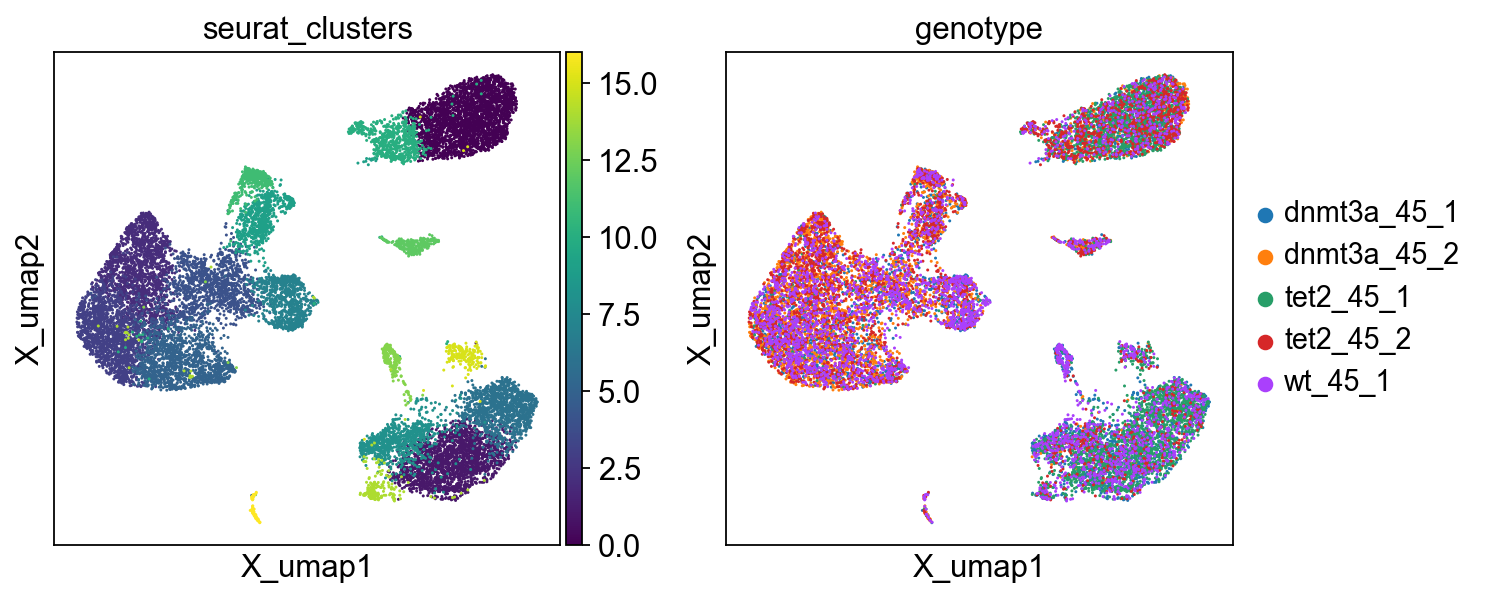

In [149]:
sc.pl.embedding(rna, "X_umap", color=["seurat_clusters", "genotype"])

Preperation for scenic : Need to make a loom file for this 

In [150]:
tfs_path = "./mm_mgi_tfs.txt"

In [151]:
loom_path = "./data/week30/pyscenic/input.loom"
loom_path_output = "./data/week30/pyscenic/output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

Its a good idea to check if the transcription factors are matching in the gene list in general atleast more than 50 percent should match

In [152]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"%{np.sum(rna.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1688 out of 1721 TFs are found in the object


Usage of only highly variable genes

In [153]:
use_hvg = True
if use_hvg:
    mask = (rna.var["highly_variable"] == True) | rna.var.index.isin(
        tfs
    )
    rna = rna[:, mask]

Creating a loom file now to prepare for scenic

In [168]:
row_attributes = {
    "Gene": np.array(rna.var.index),
}
col_attributes = {
    "CellID": np.array(rna.obs.index),
    "nGene": np.array(np.sum(rna.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(rna.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, rna.X.transpose(), row_attributes, col_attributes)

Once the loom file has been generated, we execute pyscenic to generate associations between TFs and genes. TF-gene associations are inferred by GRNBoost, and summarized by a directional weight between TFs and target genes. The output of this analysis is a table summarizing all reported associations with their importance weight.

Some steps below require indicating a number of cores (num_workers). Increase according to computing resources available

In [160]:
num_workers = 4

In [172]:
outpath_adj = "./data/week30/pyscenic/adj.csv"
!pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers}

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2024-01-07 14:34:22,160 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-01-07 14:34:24,347 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-01-07 14:34:31,515 - distributed.worker.memor

In [173]:
results_adjacencies = pd.read_csv("./data/week30/pyscenic/adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

EmptyDataError: No columns to parse from file